In [2]:
import autograd.numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots18
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [3]:
def initialize_parameters_deep(layer_dims): 
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) \
        * np.sqrt(2.0 / layer_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [4]:
from autograd import grad
def sigmoid(Z):
    return 1/(1 + np.exp(-Z)), Z

def relu(Z):
    return np.maximum(0, Z), Z

def tanh(Z):
    return np.tanh(Z), Z

def cos(Z):
    return np.cos(Z), Z

def arctan(Z):
    return np.arctan(Z), Z

def arctan_grad(Z):
    return 1/(1 + Z**2)

def softmax_help(Z):
    shift = Z - np.max(Z, axis=0)
    exps = np.exp(shift)
    return exps / np.sum(exps, axis = 0)

def softmax(Z):
    return softmax_help(Z), Z

def softmax_grad(A):
    dA = np.zeros_like(A.T)
    for i in range((A.T).shape[0]):
        s = A.T[i]
        s.reshape((-1, 1))
        dA[i] = np.diag(np.diagflat(s) * np.dot(s, s.T))
    return dA.T
    
def softplus(Z):
    return np.log(np.exp(Z) + 1), Z

def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation, dA_prev):
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
        dA = np.multiply(A, 1 - A) * np.dot(W, dA_prev)  
    
    elif activation == "relu":
        A, activation_cache = relu(Z)
        dA = np.greater_equal(Z, 0) * np.dot(W, dA_prev)
    
    elif activation == "none":
        A, activation_cache = Z, Z
        dA = np.dot(W, dA_prev)
    
    elif activation == "tanh":
        A, activation_cache = tanh(Z)
        dA = (np.ones_like(A) - A**2) * np.dot(W, dA_prev)
        
    elif activation == "cos":
        A, activation_cache = cos(Z)
        dA = - np.sin(Z) * np.dot(W, dA_prev)
    
    elif activation == "softplus":
        A, activation_cache = softplus(Z)
        dA =  sigmoid(Z)[0] * np.dot(W, dA_prev)
        
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
        dA = softmax_grad(A) * np.dot(W, dA_prev)
    
    elif activation == "arctan":
        A, activation_cache = arctan(Z)
        dA = arctan_grad(Z) * np.dot(W, dA_prev)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    assert (dA.shape == A.shape)
    cache = (linear_cache, activation_cache)

    return A, cache, dA

In [5]:
A = np.array([2, 2, 2, 2])
A = softmax_help(A)
A.reshape((-1, 1))
np.diag(np.diagflat(A) * np.dot(A, A.T))

array([ 0.0625,  0.0625,  0.0625,  0.0625])

In [6]:
A = np.array([[1, 2],[2,2], [3,2], [8, 2]])
softmax_grad(softmax_help(A))

array([[  8.84772049e-04,   6.25000000e-02],
       [  2.40505978e-03,   6.25000000e-02],
       [  6.53763030e-03,   6.25000000e-02],
       [  9.70270366e-01,   6.25000000e-02]])

In [7]:
softmax_help(A)

array([[  9.02738505e-04,   2.50000000e-01],
       [  2.45389767e-03,   2.50000000e-01],
       [  6.67038546e-03,   2.50000000e-01],
       [  9.89972978e-01,   2.50000000e-01]])

In [8]:
def L_model_forward(X, parameters, activation):
    caches = []
    A = X
    dA = np.ones_like(A)
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        dA_prev = dA
        A, cache, dA = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation, dA_prev)
        caches.append(cache)

    AL, cache, dAL = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "none", dA)
    caches.append(cache)
    
    assert(AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))
    assert(dAL.shape == AL.shape)        
    return AL, caches, dAL

In [9]:
def sigmoid_backward(dA, activation_cache):
    y = sigmoid(activation_cache)[0]
    return np.multiply(dA, np.multiply(y, 1 - y))

def relu_backward(dA, activation_cache):
    y = np.greater_equal(activation_cache, 0)
    return np.multiply(dA, y)

def none_backward(dA, activation_cache):
    return dA

def cos_backward(dA, activation_cache):
    return np.multiply(dA, -np.sin(activation_cache))

def tanh_backward(dA, activation_cache):
    return np.multiply(dA, np.ones_like(dA) - np.tanh(activation_cache)**2)

def softplus_backward(dA, activation_cache):
    return np.multiply(dA, sigmoid(activation_cache)[0])

def softmax_backward(dA, activation_cache):
    return np.multiply(dA , softmax_grad(softmax(activation_cache)[0]))

def arctan_backward(dA, activation_cache):
    return np.multiply(dA, arctan_grad(activation_cache))

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, cache[0].T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(cache[1].T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    
    elif activation == "none":
        dZ = none_backward(dA, activation_cache)
    
    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache)
        
    elif activation == "cos":
        dZ = cos_backward(dA, activation_cache)
    
    elif activation == "softplus":
        dZ = softplus_backward(dA, activation_cache)
    
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
    
    elif activation == "arctan":
        dZ = arctan_backward(dA, activation_cache)
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [10]:
def L_model_backward(AL, dAL, caches, activation):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "none")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation)
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [11]:
def initialize_adam(parameters) :   
    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    
    for l in range(L):
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]
        
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))
       
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)
        
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))
       
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s["db" + str(l + 1)] + epsilon)
      
    return parameters, v, s

In [43]:


#1: y' = 1/x^2 - y/x  using Neural Networks with intital condition y(1) = 0
#2: y' = y + (x^2)y using Neural Networks with intital condition y(0) = 1
#3: y' = cosx - sinx - y, , y(0) = 2

def solve_3():
    def dy_dx(x, y):
        return np.cos(x) - np.sin(x) - y
    
    def analytic_solution(x):
        return np.cos(x) + np.exp(-x)
    
    def predicted_soln(X, AL):
        return 2+AL*X
    
    def cost(AL, dAL, X):
        Y = 2+AL*X
        term1 = dy_dx(X, Y)
        term2 = AL + X*dAL
        cost = np.mean((term1 - term2)**2)
        cost = np.squeeze(cost)
        return cost
    
    def compute_cost(AL, dAL, X):
        return cost(AL, dAL, X), grad(cost)(AL, dAL, X)
    
    batch_size = 200
    
    def get_data():
        h = np.random.uniform(-1,1,batch_size)
        h.shape = (1, batch_size)
        return h
    
    return get_data, predicted_soln, compute_cost, analytic_solution

def solve_2():
    def dy_dx(x, y):
        return y*(1 + x**2)
    
    def analytic_solution(x):
        return np.exp(x + x**3/3)
    
    def predicted_soln(X, AL):
        return 1+AL*X
    
    def cost(AL, dAL, X):
        Y = 1+AL*X
        term1 = dy_dx(X, Y)
        term2 = AL + X*dAL
        cost = np.mean((term1 - term2)**2)
        cost = np.squeeze(cost)
        return cost
    
    def compute_cost(AL, dAL, X):
        return cost(AL, dAL, X), grad(cost)(AL, dAL, X)
    
    batch_size = 100
    
    def get_data():
        h = np.random.uniform(-0.5,0.5,batch_size)
        h.shape = (1, batch_size)
        return h
    
    return get_data, predicted_soln, compute_cost, analytic_solution
    
def solve_1():
    def analytic_solution(x):
        return np.log(x)/x

    def dy_dx(x, y):
        return 1/(x**2) - y/x
    
    def predicted_soln(X, AL):
        return AL*(X - 1)
        
    def cost(AL, dAL, X):
        Y = AL*(X - 1)
        term1 = dy_dx(X, Y)
        term2 = AL + (X-1)*dAL
        cost = np.mean((term1 - term2)**2)
        cost = np.squeeze(cost)
        return cost
    
    def compute_cost(AL, dAL, X):
        return cost(AL, dAL, X), grad(cost)(AL, dAL, X)
    
    batch_size = 500
    
    def get_data():
        h = np.random.uniform(0.5,2.5,batch_size)
        h.shape = (1, batch_size)
        return h
    
    return get_data, predicted_soln, compute_cost, analytic_solution

In [45]:
get_data, predicted, compute_cost, analytic_soln = solve_2()

layers_dims = [1, 4, 4, 4, 1]

L = len(layers_dims)             # number of layers in the neural networks
costs = []                       # to keep track of the cost
t = 0                            # initializing the counter required for Adam update
seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours

num_epochs = 4401

parameters = initialize_parameters_deep(layers_dims)
v, s = initialize_adam(parameters)

activation = 'sigmoid'

print_cost = True

for i in range(num_epochs):
    X = get_data()
    
    AL, caches, dAL = L_model_forward(X, parameters, activation)
    
    cost, dAL = compute_cost(AL, dAL, X)
   
    grads = L_model_backward(AL, dAL, caches, activation)
    
    '''
    # Perform check
    Y = dx_dt(AL)
    gradient_checker(parameters, grads, Y, X)
    break
    '''
    
    t = t + 1
    parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t)
    
    if print_cost and i % 100 == 0:
        print ("Cost after iteration %i: %f" % (i, cost))
    if print_cost and i % 100 == 0:
        costs.append(cost)

Cost after iteration 0: 1.723658
Cost after iteration 100: 0.084113
Cost after iteration 200: 0.047326
Cost after iteration 300: 0.019822
Cost after iteration 400: 0.010623
Cost after iteration 500: 0.006296
Cost after iteration 600: 0.003920
Cost after iteration 700: 0.004603
Cost after iteration 800: 0.003708
Cost after iteration 900: 0.002964
Cost after iteration 1000: 0.001587
Cost after iteration 1100: 0.002182
Cost after iteration 1200: 0.001892
Cost after iteration 1300: 0.001630
Cost after iteration 1400: 0.002117
Cost after iteration 1500: 0.001274
Cost after iteration 1600: 0.001445
Cost after iteration 1700: 0.001419
Cost after iteration 1800: 0.001445
Cost after iteration 1900: 0.001120
Cost after iteration 2000: 0.001278
Cost after iteration 2100: 0.001116
Cost after iteration 2200: 0.000906
Cost after iteration 2300: 0.000908
Cost after iteration 2400: 0.001538
Cost after iteration 2500: 0.000949
Cost after iteration 2600: 0.001173
Cost after iteration 2700: 0.000980
Cost

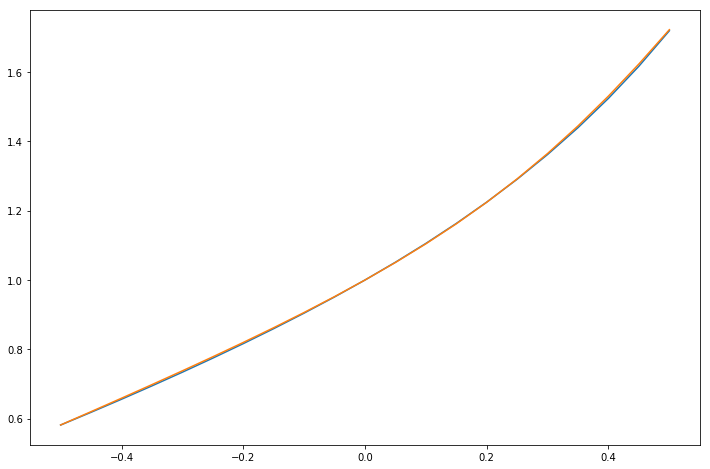

In [46]:
test = np.linspace(-0.5, 0.5, 21) #use for eqn2 and for eqn3
#test = np.linspace(0.5, 2.5, 21) #use for eqn1
test.shape = (1, 21)
approx = predicted(L_model_forward(test, parameters, activation)[0], test)
test.shape = (21, )
approx.shape = (21, )
actual = np.squeeze(analytic_soln(test))
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(test, actual, test, approx)
# plt.savefig("y' = y + (x^2)y, none.png")
#plt.savefig("y' = cosx - sinx - y, none.png")

In [54]:
test.shape = (1, 11)
AL, _, dAL = L_model_forward(test, parameters, activation)
Y = AL*(test - 1)
term1 = dy_dx(test, Y)
term2 = AL + (test-1)*dAL
term1.shape = (11, )
term2.shape = (11, )
test.shape = (11, )
plt.figure(figsize=(12,8))
plt.plot(test, term1, test, term2)

NameError: name 'dy_dx' is not defined